# Time Series stock price forcasting with LSTM

## Loading the required libraries

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import CSVLogger
from datetime import datetime
%matplotlib inline

Using TensorFlow backend.


## Loading and exploring the stock data

In [2]:
df = pd.read_csv('DJIA_table.csv', index_col='Date')

# A quick check on dataframe structure
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1989 entries, 2016-07-01 to 2008-08-08
Data columns (total 6 columns):
Open         1989 non-null float64
High         1989 non-null float64
Low          1989 non-null float64
Close        1989 non-null float64
Volume       1989 non-null int64
Adj Close    1989 non-null float64
dtypes: float64(5), int64(1)
memory usage: 108.8+ KB
None
                    Open          High           Low         Close     Volume  \
Date                                                                            
2016-07-01  17924.240234  18002.380859  17916.910156  17949.369141   82160000   
2016-06-30  17712.759766  17930.609375  17711.800781  17929.990234  133030000   
2016-06-29  17456.019531  17704.509766  17456.019531  17694.679688  106380000   
2016-06-28  17190.509766  17409.720703  17190.509766  17409.720703  112190000   
2016-06-27  17355.210938  17355.210938  17063.080078  17140.240234  138740000   

               Adj Close  
Date                   

In [3]:
df.tail()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312


In [4]:
# Sort the data based on date in ascendating order i.e oldest date first
df = df.sort_index(ascending=True)

In [5]:
df.astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1989 entries, 2008-08-08 to 2016-07-01
Data columns (total 6 columns):
Open         1989 non-null float64
High         1989 non-null float64
Low          1989 non-null float64
Close        1989 non-null float64
Volume       1989 non-null int64
Adj Close    1989 non-null float64
dtypes: float64(5), int64(1)
memory usage: 108.8+ KB


In [6]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [7]:
# Re-arrange the columns order
#columns=['Open', 'High', 'Low', 'Volume','Close']
# Use this as features
columns=['Volume','Close']
df = df[columns]

## Convert time series data into supervised data
The goal of this mini project is to predict the next day's 'Close' price of the stock.

We will re-arrange the dataframe so that the next day's 'Close' price will become the label for today date

In [8]:
# Using the next day 'Close' price as today label and we will use 'Y' as the column name
df['Y'] = df['Close'].shift(-1)

In [9]:
# A quick check on the dataframe after data re-arrangement
print(df.head(5))
print(df.shape)


               Volume         Close             Y
Date                                             
2008-08-08  212830000  11734.320312  11782.349609
2008-08-11  183190000  11782.349609  11642.469727
2008-08-12  173590000  11642.469727  11532.959961
2008-08-13  182550000  11532.959961  11615.929688
2008-08-14  159790000  11615.929688  11659.900391
(1989, 3)


## Convert to stationary time series

In [10]:
# Adding a diff column for the prediction Close price (Y) to convert into stationary data
df['Y-diff'] = df['Y'] - df['Close']

# The diff value is the different of Y value from previous day so we need to shift the data to reflect this
#df['Y-diff'] = df['Y-diff'].shift(1)

# Fill the nan cell with 0 value. The first row will be 0
df.fillna(value=0, axis=1, inplace=True)

In [11]:
print(df.head(5))
print(df.tail(5))

               Volume         Close             Y      Y-diff
Date                                                         
2008-08-08  212830000  11734.320312  11782.349609   48.029297
2008-08-11  183190000  11782.349609  11642.469727 -139.879882
2008-08-12  173590000  11642.469727  11532.959961 -109.509766
2008-08-13  182550000  11532.959961  11615.929688   82.969727
2008-08-14  159790000  11615.929688  11659.900391   43.970703
               Volume         Close             Y      Y-diff
Date                                                         
2016-06-27  138740000  17140.240234  17409.720703  269.480469
2016-06-28  112190000  17409.720703  17694.679688  284.958985
2016-06-29  106380000  17694.679688  17929.990234  235.310546
2016-06-30  133030000  17929.990234  17949.369141   19.378907
2016-07-01   82160000  17949.369141      0.000000    0.000000


In [12]:
# Let's store the original Y values in df_Y
df_Y = df['Y']
df_Y = df_Y
print(df_Y.head(10))
print(df_Y.shape)

# Drop Y from df
df.drop('Y', axis=1, inplace=True)

base_row = df.iloc[0]
# base_Y = 11782.349609
print(base_row)

print(df.info())

Date
2008-08-08    11782.349609
2008-08-11    11642.469727
2008-08-12    11532.959961
2008-08-13    11615.929688
2008-08-14    11659.900391
2008-08-15    11479.389648
2008-08-18    11348.549805
2008-08-19    11417.429688
2008-08-20    11430.209961
2008-08-21    11628.059570
Name: Y, dtype: float64
(1989,)
Volume    2.128300e+08
Close     1.173432e+04
Y-diff    4.802930e+01
Name: 2008-08-08, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 1989 entries, 2008-08-08 to 2016-07-01
Data columns (total 3 columns):
Volume    1989 non-null int64
Close     1989 non-null float64
Y-diff    1989 non-null float64
dtypes: float64(2), int64(1)
memory usage: 62.2+ KB
None


In [13]:
print(df.head(5))

               Volume         Close      Y-diff
Date                                           
2008-08-08  212830000  11734.320312   48.029297
2008-08-11  183190000  11782.349609 -139.879882
2008-08-12  173590000  11642.469727 -109.509766
2008-08-13  182550000  11532.959961   82.969727
2008-08-14  159790000  11615.929688   43.970703


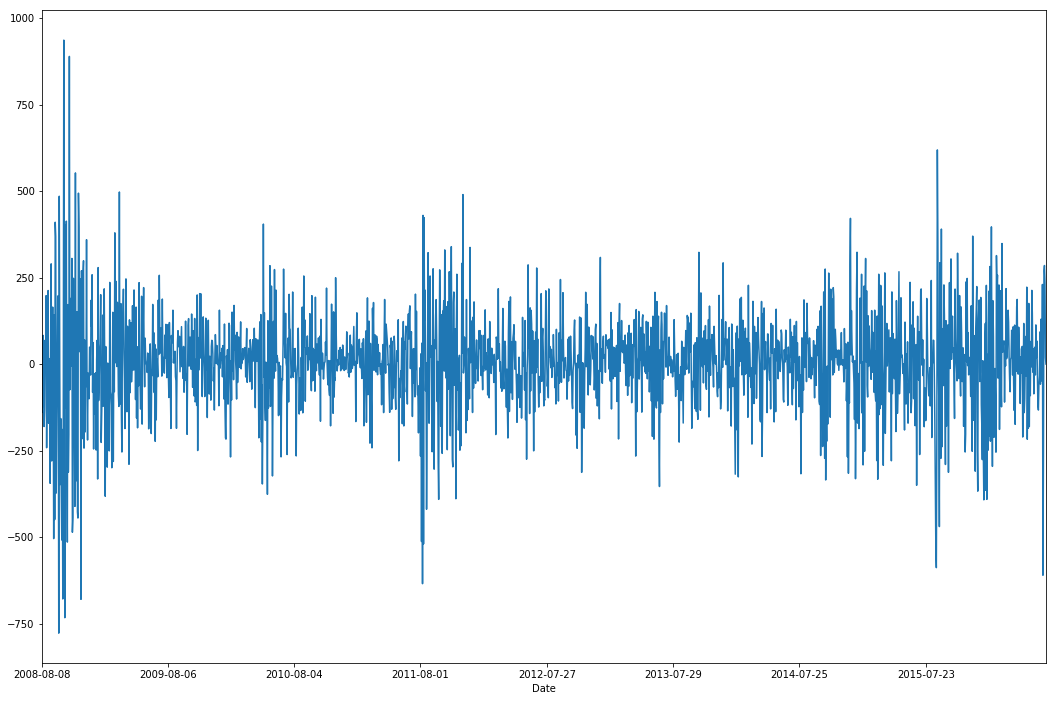

In [14]:
plt.figure(figsize=(18,12))
df['Y-diff'].plot()

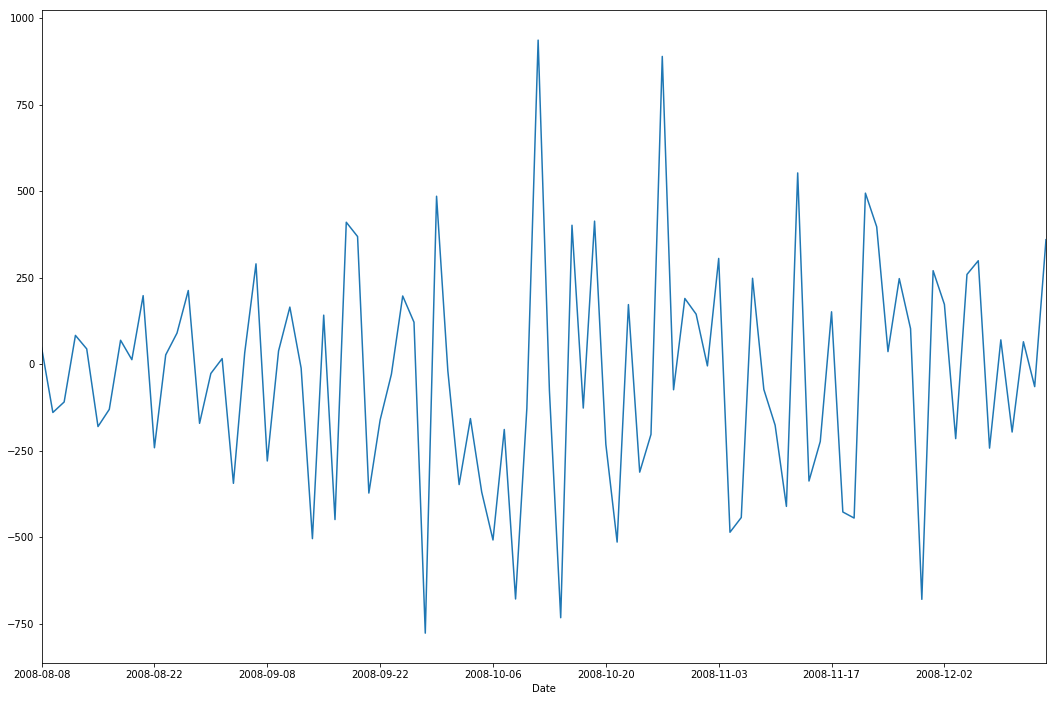

In [15]:
plt.figure(figsize=(18,12))
df['Y-diff'][:90].plot()

In [16]:
# Since we are shifting the data upward, the last row of the dataframe is containing 'Nan' value for Y
print(df.tail(5))

# We will remove this 
df = df[:-1]
print(df.tail(5))

               Volume         Close      Y-diff
Date                                           
2016-06-27  138740000  17140.240234  269.480469
2016-06-28  112190000  17409.720703  284.958985
2016-06-29  106380000  17694.679688  235.310546
2016-06-30  133030000  17929.990234   19.378907
2016-07-01   82160000  17949.369141    0.000000
               Volume         Close      Y-diff
Date                                           
2016-06-24  239000000  17400.750000 -260.509766
2016-06-27  138740000  17140.240234  269.480469
2016-06-28  112190000  17409.720703  284.958985
2016-06-29  106380000  17694.679688  235.310546
2016-06-30  133030000  17929.990234   19.378907


## Quick visualization of the data correlation

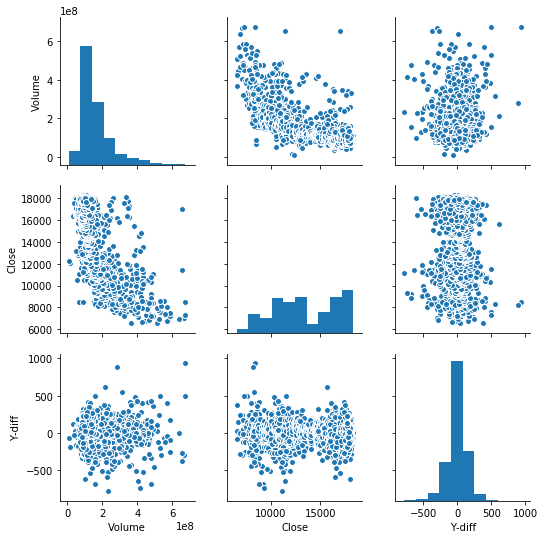

In [17]:
sns.pairplot(df)

In [18]:
df.corr()

,Volume,Close,Y-diff
Volume,1.000000,-0.694149,-0.000697
Close,-0.694149,1.000000,-0.013231
Y-diff,-0.000697,-0.013231,1.000000


In [19]:
# Checking co-efficient of the data
from sklearn.linear_model import LinearRegression

# create X and y
X = df[columns]
y = df['Y-diff']

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print(columns)
print(linreg.coef_)

['Volume', 'Close']
[ -2.91061281e-08  -1.20724381e-03]


## Data normalization 
Let's normalize our data for the machine learning algorithms to function better
We will use MinMaxScaler

In [20]:
data = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [21]:
# Split data into train and test scaled_data 
train_size = int(len(scaled_data) * 0.95)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
print(len(scaled_data), len(train), len(test))
print(scaled_data.shape, train.shape, test.shape)

1988 1888 100
(1988, 3) (1888, 3) (100, 3)


In [22]:
# Split data into features X, and lable y
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X)
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

[[ 0.30670207  0.4408942 ]
 [ 0.26223162  0.44497647]
 [ 0.24782824  0.43308732]
 ..., 
 [ 0.1846634   0.8388648 ]
 [ 0.19594605  0.82087889]
 [ 0.23626052  0.80575651]]
(1888, 2) (1888,)
(100, 2) (100,)


## Define the LSTM model parameters

In [23]:
# Reshape input data to 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# Reshape output to 2D 
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1888, 1, 2) (1888, 1) (100, 1, 2) (100, 1)


In [24]:
# Parameters for LSTM model

batchsize=4
epoch=100
optimizer='adam'
neurons=8
now = datetime.now().strftime('%Y%m%d_%H%M')
outfile='logs/loss_%s_batchsize_%s_epoch_%s_neurons_%s_optimizer_%s_log.csv' % (now, batchsize, epoch, neurons, optimizer)

# create and fit the LSTM network
csv_logger = CSVLogger(outfile)
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
#model.fit(train_X, train_y, epochs=epoch, batch_size=batchsize, verbose=0 ,shuffle=False, callbacks=[csv_logger] )

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), callbacks=[csv_logger], verbose=1, shuffle=False)


# Reading the RMSE losses from the training output file and plot it
'''
rmse_loss= pd.read_csv(outfile)
label="_".join(outfile.split('_')[3:-1])
plt.figure(figsize=(8,6))
plt.plot(rmse_loss.epoch, rmse_loss.loss, label=label)
plt.legend()
plt.show()
'''




Train on 1888 samples, validate on 100 samples
Epoch 1/50
1888/1888 [==============================] - 0s - loss: 0.2810 - val_loss: 0.2894
Epoch 2/50
1888/1888 [==============================] - 0s - loss: 0.2190 - val_loss: 0.2240
Epoch 3/50
1888/1888 [==============================] - 0s - loss: 0.1700 - val_loss: 0.1713
Epoch 4/50
1888/1888 [==============================] - 0s - loss: 0.1295 - val_loss: 0.1272
Epoch 5/50
1888/1888 [==============================] - 0s - loss: 0.0952 - val_loss: 0.0901
Epoch 6/50
1888/1888 [==============================] - 0s - loss: 0.0667 - val_loss: 0.0599
Epoch 7/50
1888/1888 [==============================] - 0s - loss: 0.0442 - val_loss: 0.0369
Epoch 8/50
1888/1888 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0215
Epoch 9/50
1888/1888 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0127
Epoch 10/50
1888/1888 [==============================] - 0s - loss: 0.0115 - val_loss: 0.0087ss: 0.01
Epoch 11/50
18

'\nrmse_loss= pd.read_csv(outfile)\nlabel="_".join(outfile.split(\'_\')[3:-1])\nplt.figure(figsize=(8,6))\nplt.plot(rmse_loss.epoch, rmse_loss.loss, label=label)\nplt.legend()\nplt.show()\n'

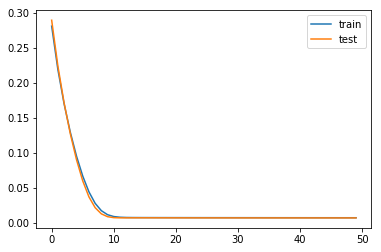

In [25]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Visualization of the Model

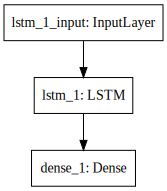

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [27]:
# Predict the next day's Close price (Y) for both training and test data
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

## Convert data back to its original format

Example output shape

train_X.shape trainPredict.shape

(352, 1, 5)    (352, 1)


In [28]:
train_X.reshape(len(train_X),train_X.shape[2]).shape

(1888, 2)

## Reshape

In [29]:
def reshape_to_orig(x,y):
    '''
    Merging x and y into its original series shape.
    
    Reshape x from (rows_count,1,cols_count) => (rows_count,cols_count) 
    and concat with y in the shape (rows_count,1)
    For example: (88, 1, 5) + (88, 1) => (88,6)
    
    '''
    return np.hstack((x.reshape(len(x),x.shape[2]), y))

In [30]:
# Calling reshape_to_orig function to reshape both the training aand test data
trainPredict2 = reshape_to_orig(train_X,trainPredict)
trainY2 = reshape_to_orig(train_X,train_y)

testPredict2 = reshape_to_orig(test_X,testPredict)
testY2 = reshape_to_orig(test_X,test_y)

print(trainPredict2.shape, trainY2.shape)
print(testPredict2.shape, testY2.shape)
print(trainPredict2[:3])
print(trainPredict[:3,-1])

(1888, 3) (1888, 3)
(100, 3) (100, 3)
[[ 0.30670207  0.4408942   0.45630088]
 [ 0.26223162  0.44497647  0.45201597]
 [ 0.24782824  0.43308732  0.44997305]]
[ 0.45630088  0.45201597  0.44997305]


## Invert the scaling

In [31]:
# We have normalized/scaled our data before feeding into the model
# Now time to transform it back to the original matrix

trainPredict_orig = scaler.inverse_transform(trainPredict2)
trainY_orig = scaler.inverse_transform(trainY2)

testPredict_orig = scaler.inverse_transform(testPredict2)
testY_orig = scaler.inverse_transform(testY2)


'''
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY_orig[:,-1], trainPredict_orig[:,-1]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY_orig[:,-1], testPredict_orig[:,-1]))
print('Test Score: %.3f RMSE' % (testScore))

'''

print(trainPredict_orig.shape, trainY_orig.shape)
print(testPredict_orig.shape, testY_orig.shape)
print(trainPredict_orig[:4])
print(trainY_orig[:4])

(1888, 3) (1888, 3)
(100, 3) (100, 3)
[[  2.12830000e+08   1.17343203e+04   4.46548014e+00]
 [  1.83190000e+08   1.17823496e+04  -2.87929666e+00]
 [  1.73590000e+08   1.16424697e+04  -6.38106400e+00]
 [  1.82550000e+08   1.15329600e+04  -4.83530873e+00]]
[[  2.12830000e+08   1.17343203e+04   4.80292970e+01]
 [  1.83190000e+08   1.17823496e+04  -1.39879882e+02]
 [  1.73590000e+08   1.16424697e+04  -1.09509766e+02]
 [  1.82550000e+08   1.15329600e+04   8.29697270e+01]]


## Invert the stationary data back to the original data format

In [32]:
# Add the diff with the Close price
train_inv = trainPredict_orig[:,-2] + trainPredict_orig[:,-1]
test_inv = testPredict_orig[:,-2] + testPredict_orig[:,-1]

df_plot = df
print(df_plot.shape, train_inv.shape, test_inv.shape,)
df_plot['Y'] = df_Y
df_plot['Y_Predict'] = np.append(train_inv,test_inv)

print(df_plot.tail(5))

(1988, 3) (1888,) (100,)
               Volume         Close      Y-diff             Y     Y_Predict
Date                                                                       
2016-06-24  239000000  17400.750000 -260.509766  17140.240234  17451.630129
2016-06-27  138740000  17140.240234  269.480469  17409.720703  17161.888992
2016-06-28  112190000  17409.720703  284.958985  17694.679688  17425.712402
2016-06-29  106380000  17694.679688  235.310546  17929.990234  17710.871739
2016-06-30  133030000  17929.990234   19.378907  17949.369141  17955.170490


## Calculate the RMSE

In [33]:
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(df_plot['Y'][:train_size], df_plot['Y_Predict'][:train_size]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(df_plot['Y'][train_size:], df_plot['Y_Predict'][train_size:]))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 144.823 RMSE
Test Score: 142.364 RMSE


# Plotting the data
Plotting the train and test data vs the actual next day's Close price

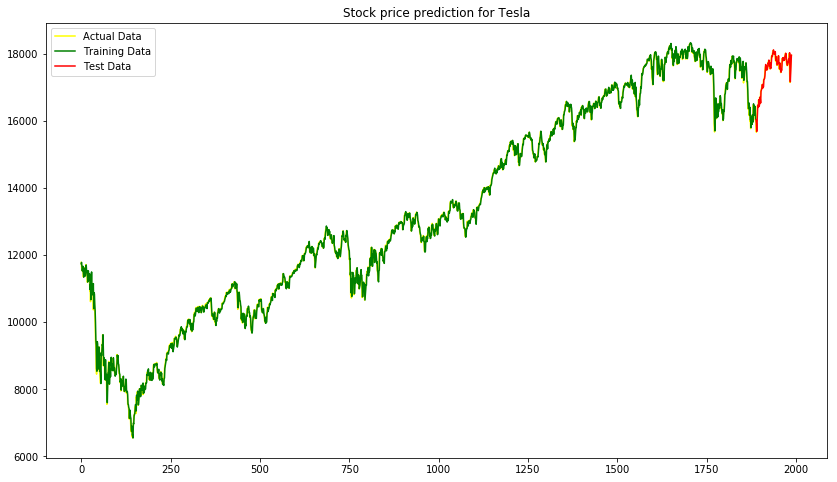

In [34]:

# The actual 'Close' price for next day - actual Y value
data_plot = data[:,-1].reshape(-1,1)

data_plot = df['Y'].values.reshape(-1,1)
#print(data_plot.shape)
#print(data_plot)

# Predicted Close price for the training data
train_plot = np.empty_like(data_plot)
train_plot[:,:] = np.nan
train_plot[:train_size,:] = df['Y_Predict'][:train_size].values.reshape(-1,1)

#train_plot = df['Y_Predict'][:train_size].values
#print(train_plot.shape)

test_plot = np.empty_like(data_plot)
test_plot[:,:] = np.nan
test_plot[train_size:,:] = df['Y_Predict'][train_size:].values.reshape(-1,1)

#test_plot = df['Y_Predict'][train_size:].values
#print(test_plot.shape)

plt.figure(figsize=(14,8))
plt.plot(data_plot, color='yellow', label='Actual Data')
plt.plot(train_plot, color='green', label='Training Data')
plt.plot(test_plot, color='red', label='Test Data')
plt.title('Stock price prediction for Tesla')
plt.legend()
plt.show()

In [35]:
# Actual data 

print(df_plot[['Y_Predict', 'Y']].tail(30))

               Y_Predict             Y
Date                                  
2016-05-19  17446.883965  17500.939453
2016-05-20  17517.462018  17492.929688
2016-05-23  17502.603401  17706.050781
2016-05-24  17716.711747  17851.509766
2016-05-25  17861.031044  17828.289062
2016-05-26  17834.764141  17873.220703
2016-05-27  17881.183557  17787.199219
2016-05-31  17815.464804  17789.669922
2016-06-01  17798.615737  17838.560547
2016-06-02  17846.975445  17807.060547
2016-06-03  17817.173891  17920.330078
2016-06-06  17928.216204  17938.279297
2016-06-07  17948.227996  18005.050781
2016-06-08  18013.298327  17985.189453
2016-06-09  17992.866389  17865.339844
2016-06-10  17878.159473  17732.480469
2016-06-13  17747.595666  17674.820312
2016-06-14  17687.329196  17640.169922
2016-06-15  17652.567596  17733.099609
2016-06-16  17745.475419  17675.160156
2016-06-17  17730.504478  17804.869141
2016-06-20  17819.796399  17829.730469
2016-06-21  17840.795817  17780.830078
2016-06-22  17792.801710 

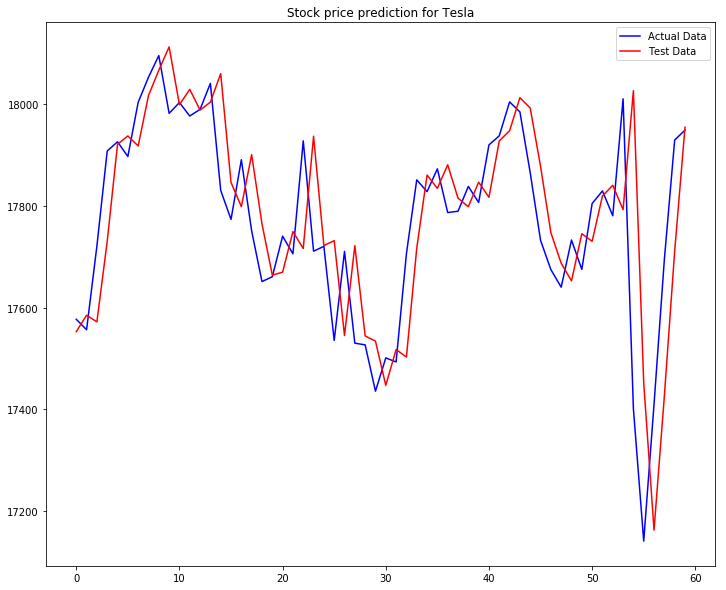

In [36]:
# This is to zoom into the last 60 days of the prediction
plt.figure(figsize=(12,10))
plt.plot(data_plot[-60:,-1], color='blue', label='Actual Data')
plt.plot(test_plot[-60:,-1], color='red', label='Test Data')
plt.title('Stock price prediction for Tesla')
plt.legend()
plt.show()

In [37]:
news_data = pd.read_csv('Combined_News_DJIA.csv')

# DJIA stocks prediction and Reddit News

We will use Kaggle data to 
https://www.kaggle.com/ndrewgele/omg-nlp-with-the-djia-and-reddit

In [38]:
print(news_data)

            Date  Label                                               Top1  \
0     2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1     2008-08-11      1  b'Why wont America and Nato help us? If they w...   
2     2008-08-12      0  b'Remember that adorable 9-year-old who sang a...   
3     2008-08-13      0  b' U.S. refuses Israel weapons to attack Iran:...   
4     2008-08-14      1  b'All the experts admit that we should legalis...   
5     2008-08-15      1  b"Mom of missing gay man: Too bad he's not a 2...   
6     2008-08-18      0  b'In an Afghan prison, the majority of female ...   
7     2008-08-19      0  b"Man arrested and locked up for five hours af...   
8     2008-08-20      1  b'Two elderly Chinese women have been sentence...   
9     2008-08-21      1  b"British resident held in Guantanamo Bay wins...   
10    2008-08-22      1  b'Syria says its ready to put a Russian missil...   
11    2008-08-25      0  b"N Korea's Kim died in 2003; replaced 

In [39]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 27 columns):
Date     1989 non-null object
Label    1989 non-null int64
Top1     1989 non-null object
Top2     1989 non-null object
Top3     1989 non-null object
Top4     1989 non-null object
Top5     1989 non-null object
Top6     1989 non-null object
Top7     1989 non-null object
Top8     1989 non-null object
Top9     1989 non-null object
Top10    1989 non-null object
Top11    1989 non-null object
Top12    1989 non-null object
Top13    1989 non-null object
Top14    1989 non-null object
Top15    1989 non-null object
Top16    1989 non-null object
Top17    1989 non-null object
Top18    1989 non-null object
Top19    1989 non-null object
Top20    1989 non-null object
Top21    1989 non-null object
Top22    1989 non-null object
Top23    1988 non-null object
Top24    1986 non-null object
Top25    1986 non-null object
dtypes: int64(1), object(26)
memory usage: 419.6+ KB


In [40]:
train = news_data[news_data['Date'] < '2015-01-01']
test = news_data[news_data['Date'] > '2014-12-31']

In [41]:
train.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [42]:
test.tail(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
1986,2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,...,"Escape Tunnel, Dug by Hand, Is Found at Holoca...",The land under Beijing is sinking by as much a...,Car bomb and Anti-Islamic attack on Mosque in ...,Emaciated lions in Taiz Zoo are trapped in blo...,Rupert Murdoch describes Brexit as 'wonderful'...,More than 40 killed in Yemen suicide attacks,Google Found Disastrous Symantec and Norton Vu...,Extremist violence on the rise in Germany: Dom...,BBC News: Labour MPs pass Corbyn no-confidence...,Tiny New Zealand town with 'too many jobs' lau...
1987,2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,...,Googles free wifi at Indian railway stations i...,Mounting evidence suggests 'hobbits' were wipe...,The men who carried out Tuesday's terror attac...,Calls to suspend Saudi Arabia from UN Human Ri...,More Than 100 Nobel Laureates Call Out Greenpe...,British pedophile sentenced to 85 years in US ...,"US permitted 1,200 offshore fracks in Gulf of ...",We will be swimming in ridicule - French beach...,UEFA says no minutes of silence for Istanbul v...,Law Enforcement Sources: Gun Used in Paris Ter...
1988,2016-07-01,1,A 117-year-old woman in Mexico City finally re...,IMF chief backs Athens as permanent Olympic host,"The president of France says if Brexit won, so...",British Man Who Must Give Police 24 Hours' Not...,100+ Nobel laureates urge Greenpeace to stop o...,Brazil: Huge spike in number of police killing...,Austria's highest court annuls presidential el...,"Facebook wins privacy case, can track any Belg...",...,"The United States has placed Myanmar, Uzbekist...",S&amp;P revises European Union credit rating t...,India gets $1 billion loan from World Bank for...,U.S. sailors detained by Iran spoke too much u...,Mass fish kill in Vietnam solved as Taiwan ste...,Philippines president Rodrigo Duterte urges pe...,Spain arrests three Pakistanis accused of prom...,"Venezuela, where anger over food shortages is ...",A Hindu temple worker has been killed by three...,Ozone layer hole seems to be healing - US &amp...


In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [44]:
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))

In [45]:
'''
basicvectorizer = CountVectorizer()
basictrain = basicvectorizer.fit_transform(trainheadlines)
print(basictrain.shape)

'''

advancedvectorizer = CountVectorizer(ngram_range=(2,2))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)
print(advancedtrain)

  (0, 180118)	1
  (0, 201442)	1
  (0, 123059)	1
  (0, 146903)	1
  (0, 216677)	1
  (0, 228685)	1
  (0, 128993)	1
  (0, 41218)	1
  (0, 155811)	1
  (0, 200552)	1
  (0, 128874)	1
  (0, 303706)	1
  (0, 346746)	1
  (0, 361394)	1
  (0, 365787)	1
  (0, 190451)	1
  (0, 218225)	1
  (0, 96556)	1
  (0, 365220)	1
  (0, 226072)	1
  (0, 284912)	1
  (0, 159393)	1
  (0, 14276)	1
  (0, 22358)	1
  (0, 196323)	1
  :	:
  (1610, 217391)	1
  (1610, 318424)	1
  (1610, 125796)	1
  (1610, 326374)	1
  (1610, 59406)	1
  (1610, 217390)	2
  (1610, 180633)	2
  (1610, 30160)	1
  (1610, 279447)	1
  (1610, 35646)	1
  (1610, 275163)	1
  (1610, 266440)	1
  (1610, 214951)	1
  (1610, 230445)	1
  (1610, 316386)	1
  (1610, 224320)	1
  (1610, 33199)	1
  (1610, 315485)	1
  (1610, 328626)	2
  (1610, 319645)	1
  (1610, 33661)	2
  (1610, 35989)	1
  (1610, 123854)	1
  (1610, 159733)	1
  (1610, 225558)	2


In [46]:
advancedmodel = LogisticRegression()
advancedmodel = advancedmodel.fit(advancedtrain, train["Label"])

In [47]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest)


NameError: name 'basicvectorizer' is not defined

In [ ]:
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

In [ ]:
basicwords = basicvectorizer.get_feature_names()
basiccoeffs = basicmodel.coef_.tolist()[0]
coeffdf = pd.DataFrame({'Word' : basicwords, 
                        'Coefficient' : basiccoeffs})
coeffdf = coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeffdf.head(10)

In [ ]:
coeffdf.tail(10)